# 1. 机器翻译数据集

In [1]:
import os
import torch
from d2l import torch as d2l

In [2]:
# 下载和预处理数据集
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                          '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    """载入 “英语-法语” 数据集 """
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding='utf-8') as f:
        return f.read()
    
raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [3]:
# 几个预处理步骤
# 第一步是把标点符号和单词给隔离开来
def preprocess_nmt(text):
    """预处理 “英语-法语” 数据集"""
    
    def no_space(char, prev_char):
        # 如果当前符号是标点，并且前面没有空格的话，那么需要在标点符号前面插入一个空格
        return char in set(',.!?') and prev_char != ' '
    
    # 把半角/全角之类的空格换成ascii的空格，并且所有字符全部换成小写的
    text = text.replace('\u202f', ' ').replace('\xa0',' ').lower()
    out = [
        ' ' + char if i > 0 and no_space(char, text[i - 1]) else char
        for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [4]:
# 词元化
# 即：将每个句子按照词语的维度来分割开
def tokenize_nmt(text, num_examples=None):
    """词元化 “英语-法语” 数据数据集 """
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        # 如果超出我们需要的词数，那么就break掉
        if num_examples and i > num_examples:
            break
        
        # 按英语和法语之间的\t来分割两个语言的句子
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))  # 英语
            target.append(parts[1].split(' '))  # 法语
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

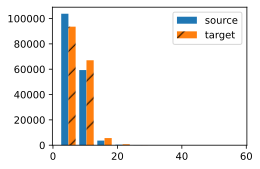

In [5]:
# 绘制每个文本序列所包含的标记数量的直方图，根据句子长度做的直方图
d2l.set_figsize()
# 统计每个句子的长度，并绘制直方图；可以发现句子长度都不太长
_, _, patches = d2l.plt.hist([ [len(l) for l in source], [len(l) for l in target] ],
                            label = ['source','target'])

for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right')

In [6]:
# 词汇表
# pad表示填充，bos 表示句子开始，eos表示句子结束
# min_freq=2表示如果某个词在整个文本中出现的次数小于2（也即只出现过一次），那么我们就不要这个词了（也即不将该词放进vocabulary中了）
src_vocab = d2l.Vocab(source, min_freq=2,
                     reserved_tokens=['<pad>','<bos>','<eos>'])

# source中共有约一万个词左右
len(src_vocab)

10012

In [7]:
# 序列样本都有一个固定长度截断或填充文本序列
# 如果句子长度超过num_steps，就做截断；如果长度没到num_steps，那么用<pad>来做填充
# 这样保证每句话的长度是一样的，便于训练
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token] * (num_steps - len(line))

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [8]:
# 转换成小批量数据集用于训练
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]  # 每个句子后面加了一个截止符
    
    # 对每句话填补长度为num_steps，并转成tensor
    array = torch.tensor([ truncate_pad(l, num_steps, vocab['<pad>']) for l in lines ])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    
    return array, valid_len  # valid_len 为原始句子的实际长度

In [9]:
# 训练模型
# 将上面的所有函数汇总在一起
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词汇表"""
    
    text = preprocess_nmt(read_data_nmt())  # 下载数据集，并分隔标点符号
    source, target = tokenize_nmt(text, num_examples)  # 将句子划分为单词
    
    # 构建source和target的vocab
    src_vocab = d2l.Vocab(source, min_freq=2,
                         reserved_tokens=['<pad>','<bos>','<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                         reserved_tokens=['<pad>','<bos>','<eos>'])
    
    # 构建完成后，将所有句子都转换成维度相同的tensor
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)  
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    
    # 返回一个iterator，一个source的vocab和一个target的vocab
    return data_iter, src_vocab, tgt_vocab

In [12]:
# 读出 “英语-法语” 数据集中第一个小批量数据
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)  
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: tensor([[ 80,  12,   4,   3,   1,   1,   1,   1],
        [139,  12,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
valid lengths for X: tensor([4, 4])
Y: tensor([[  0,   5,   3,   1,   1,   1,   1,   1],
        [111,   0,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
valid lengths for Y: tensor([3, 4])
